In [111]:
ls

2Autoencoder.ipynb    generator_notebook.ipynb  lens_dataset_2000.h5
Dark_satelite2.ipynb  generator.py              lens_dataset.h5
Dark_satelite.ipynb   lens_2000_no_sc.h5


### Inspección del dataset

Este será el conjunto de datos con los que se entrenará al doble-autoencoder.
La primera imagen será la entrada del mismo; las otras dos serán los targets que queremos emular.

In [112]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import trange

Available datasets: ['delta_psi_maps', 'images_noisy', 'images_smooth', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_noisy shape: (1000, 100, 100)
images_smooth shape: (1000, 100, 100)
delta_psi_maps shape: (1000, 100, 100)
subhalo_mass shape: (1000,)
subhalo_x shape: (1000,)
subhalo_y shape: (1000,)
Plotting samples: [117 993 592]


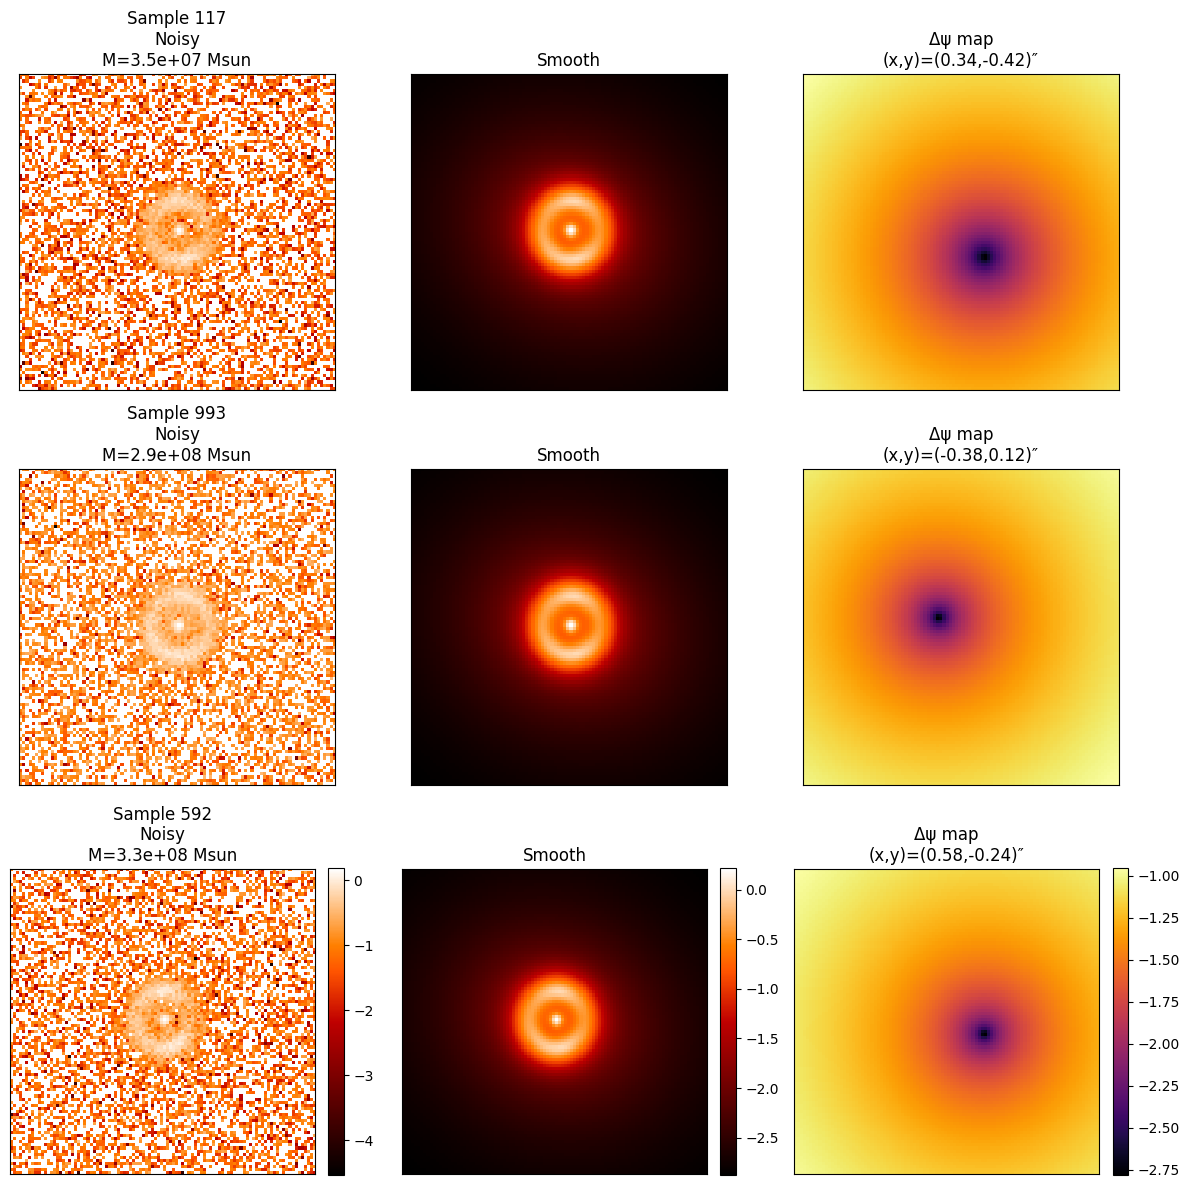

In [113]:

# Path to your HDF5 file
h5_path = 'lens_2000_no_sc.h5'

# Open the file and inspect
with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_noisy shape:", f['images_noisy'].shape)
    print("images_smooth shape:", f['images_smooth'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_noisy'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Plot each sample as a row of three panels
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
    for row, idx in enumerate(sample_indices):
        img_noisy   = f['images_noisy'][idx]
        img_smooth  = f['images_smooth'][idx]
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: Noisy image
        im0 = axes[row, 0].imshow(img_noisy, origin='lower', cmap='gist_heat')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy\nM={mass:.1e} Msun")
        # Panel 2: Smooth target
        im1 = axes[row, 1].imshow(img_smooth, origin='lower', cmap='gist_heat')
        axes[row, 1].set_title("Smooth")
        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='inferno')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Add colorbars only on the last row (or adjust as desired)
        if row == 2:
            fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


### Paso 1: Leer datos desde HDF5

Abrimos el archivo en modo lectura y cargamos tres arreglos principales:

- **$X_{\text{noisy}}$**: imágenes ruidosas de forma $(N, H, W)$  
- **$Y_{\text{smooth}}$**: imágenes suavizadas de forma $(N, H, W)$  
- **$Y_{\Delta\psi}$**: mapas de corrección $\Delta\psi$ de forma $(N, H, W)$  

```python
with h5py.File('lens_dataset.h5', 'r') as f:
    X_noisy  = f['images_noisy'][:]    # (N, H, W)
    Y_smooth = f['images_smooth'][:]   # (N, H, W)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W)


In [114]:
# 1) Leer directamente desde HDF5
with h5py.File('lens_2000_no_sc.h5', 'r') as f:
    X_noisy  = f['images_noisy'][:]    # (N, H, W)
    Y_smooth = f['images_smooth'][:]   # (N, H, W)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W)
    # ... (masas y posiciones si las necesitas)

### Step 2: Clean NaNs/Infs & Convert to Tensors

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.



In [115]:
# 2) LIMPIAR NaN e Inf **antes** de crear tensores
#    Aquí sustituimos NaN→0 y cualquier ±Inf al valor finito máximo representable.
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores y añadir canal
X  = torch.from_numpy(X_noisy).float().unsqueeze(1)  # (N,1,H,W)
Y1 = torch.from_numpy(Y_smooth).float().unsqueeze(1)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)

# 4) Normalizar usando estadísticas del train set más adelante...
#    (pero es crucial hacerlo *después* de limpiar)

In [116]:
# 5) Split en train/val/test
idx = np.arange(X.shape[0])
idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)
idx_train, idx_val  = train_test_split(idx_train, test_size=0.1111, random_state=42)

X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

In [117]:
# 6) Estadísticas y normalización (solo stats de TRAIN)
mean_X,  std_X  = X_train.mean(),  X_train.std()
mean_Y1, std_Y1 = Y1_train.mean(), Y1_train.std()
mean_Y2, std_Y2 = Y2_train.mean(), Y2_train.std()

def normalize(t, m, s):
    return (t - m) / s

X_train = normalize(X_train, mean_X,  std_X)
X_val   = normalize(X_val,   mean_X,  std_X)
X_test  = normalize(X_test,  mean_X,  std_X)

Y1_train = normalize(Y1_train, mean_Y1, std_Y1)
Y1_val   = normalize(Y1_val,   mean_Y1, std_Y1)
Y1_test  = normalize(Y1_test,  mean_Y1, std_Y1)

Y2_train = normalize(Y2_train, mean_Y2, std_Y2)
Y2_val   = normalize(Y2_val,   mean_Y2, std_Y2)
Y2_test  = normalize(Y2_test,  mean_Y2, std_Y2)


### Step 7: Dataset & DataLoader

In this stage we wrap our tensors into a PyTorch `Dataset` and then feed it into a `DataLoader` for efficient minibatch sampling:

- **Custom `LensDataset`**  
  - Holds three parallel tensors: the noisy inputs $$X$$, the smooth targets $$Y_{1}$$, and the Δψ targets $$Y_{2}$$.  
  - Implements `__len__` to report the total number of samples $$N$$.  
  - Implements `__getitem__` to return the $i$-th triplet $(x_i, y_{1,i}, y_{2,i})$.  
  - Optionally applies a small Gaussian perturbation to the input $x_i$ when `augment=True`, i.e.  
    $$
      x_i \;\longmapsto\; x_i + \mathcal{N}(0,\,0.01^2)
    $$  
    to improve robustness.

- **DataLoader instantiation**  
  - `train_loader` draws shuffled minibatches of size 32 from the training split, applying augmentation.  
  - `val_loader` draws sequential minibatches of size 32 from the validation split, without augmentation.  
  - `num_workers=4` enables parallel data loading for better GPU utilization.  


In [118]:
# 7) Dataset y DataLoader (igual que antes)
class LensDataset(Dataset):
    def __init__(self, X, Y1, Y2, augment=False):
        self.X, self.Y1, self.Y2 = X, Y1, Y2
        self.augment = augment
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        x, y1, y2 = self.X[i], self.Y1[i], self.Y2[i]
        if self.augment:
            noise = torch.randn_like(x) * 0.01
            x = x + noise
        return x, y1, y2

train_ds = LensDataset(X_train, Y1_train, Y2_train, augment=True)
val_ds   = LensDataset(X_val,   Y1_val,   Y2_val,   augment=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)


### Step 8: Model Definition

**Device detection**  
We select GPU if available, otherwise CPU:  
$$
\text{device} = \texttt{cuda}\;\text{if available else}\;\texttt{cpu}.
$$

**Shared encoder**  
The encoder $E$ repeatedly applies 2D convolutions with stride 2 to downsample:
$$
x \in \mathbb{R}^{1\times100\times100}
\;\xrightarrow{\;\text{Conv2d}(1\to16,\,3\times3,\,s=2)\;}\;
16\times50\times50
\;\xrightarrow{\;\text{Conv2d}(16\to32,\,3\times3,\,s=2)\;}\;
32\times25\times25
\;\xrightarrow{\;\text{Conv2d}(32\to64,\,3\times3,\,s=2)\;}\;
64\times13\times13
$$
Formally, the encoder is a mapping
$$
E: \mathbb{R}^{1\times100\times100} \;\longrightarrow\; \mathbb{R}^{64\times13\times13}.
$$

**Two parallel decoders**  
Each decoder $D$ uses transposed convolutions to invert the downsampling:
$$
64\times13\times13
\;\xrightarrow{\;\text{ConvTranspose2d}(64\to32,\,3\times3,\,s=2)\;}\;
32\times25\times25
\;\xrightarrow{\;\text{ConvTranspose2d}(32\to16,\,3\times3,\,s=2)\;}\;
16\times50\times50
\;\xrightarrow{\;\text{ConvTranspose2d}(16\to1,\,3\times3,\,s=2)\;}\;
1\times100\times100
$$
We define:
- **Decoder for smooth image**: $\hat Y_{\text{smooth}} = D_{1}(z)$.  
- **Decoder for $\Delta\psi$ map**: $\hat Y_{\Delta\psi} = D_{2}(z)$.

**Complete network**  
The full model is
$$
z = E(x),\quad
\bigl(\hat Y_{\text{smooth}}, \,\hat Y_{\Delta\psi}\bigr)
= \bigl(D_{1}(z),\,D_{2}(z)\bigr),
$$
with input $x\in\mathbb{R}^{1\times100\times100}$ and outputs in the same shape.


In [119]:
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2) Definición del modelo
class DoubleReconstructionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder compartido
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),   # →16×50×50
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),  # →32×25×25
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU()   # →64×13×13
        )
        # Decoder para la imagen suave
        self.decoder_smooth = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=0), nn.ReLU(),  # →32×25×25
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1), nn.ReLU(),  # →16×50×50
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(16,  1, 3, 2, 1, output_padding=1),             # → 1×100×100
            nn.Identity()
        )
        # Decoder para el mapa Δψ
        self.decoder_delta = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=0), nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(16,  1, 3, 2, 1, output_padding=1),
            nn.Identity()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder_smooth(z), self.decoder_delta(z)


# import torch.nn.functional as F

# class DoubleReconstructionCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Encoder igual que antes
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),  # 1→16, H×W → H/2×W/2
#             nn.Conv2d(16,32, 3, 2, 1), nn.ReLU(),  # →32, H/4×W/4
#             nn.Conv2d(32,64, 3, 2, 1), nn.ReLU(),  # →64, H/8×W/8
#         )
#         # Decoder “agnóstico” al tamaño: Upsample + Conv
#         def make_upsample_block(in_ch, out_ch):
#             return nn.Sequential(
#                 nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#                 nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
#                 nn.ReLU()
#             )
#         self.up1_s = make_upsample_block(64, 32)
#         self.up2_s = make_upsample_block(32, 16)
#         self.up3_s = make_upsample_block(16,  1)  # → canal 1 para smooth
        
#         self.up1_d = make_upsample_block(64, 32)
#         self.up2_d = make_upsample_block(32, 16)
#         self.up3_d = make_upsample_block(16,  1)  # → canal 1 para delta

#     def forward(self, x):
#         z = self.encoder(x)        # → (N, 64, H/8, W/8)
#         # Smooth branch
#         s = self.up1_s(z)          # → (N, 32, H/4, W/4)
#         s = self.up2_s(s)          # → (N, 16, H/2, W/2)
#         s = self.up3_s(s)          # → (N,  1,   H,   W)
#         # Delta branch
#         d = self.up1_d(z)
#         d = self.up2_d(d)
#         d = self.up3_d(d)
#         return s, d


In [120]:
# 3) Instanciar modelo, pérdida, optimizador
model    = DoubleReconstructionCNN().to(device)
loss_fn  = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),  
                             weight_decay=1e-5,   # L2 regularization
                             lr=0.001)
                             

### Step 9: Training and Validation Functions

We define two routines that iterate over the data in minibatches:

- **Training routine** (`train_epoch`):  
  1. Set the model to training mode (`model.train()`).  
  2. For each batch \((x, y_s, y_d)\):
     - Move data to the selected device.
     - Zero the gradients.
     - Compute predictions \(\hat y_s, \hat y_d = \text{model}(x)\).
     - Compute the composite loss
       $$
         \mathcal{L}
         = \frac{1}{B}\sum_{i=1}^{B}
           \Bigl\|\hat y_s^{(i)} - y_s^{(i)}\Bigr\|^2
           \;+\;\alpha\,
           \Bigl\|\hat y_d^{(i)} - y_d^{(i)}\Bigr\|^2,
       $$
       where \(B\) is the batch size and \(\alpha\) weights the Δψ term.
     - Backpropagate (`loss.backward()`), apply gradient clipping
       $$
         \|\nabla_\theta \mathcal{L}\|_2 \;\le\; 1.0,
       $$
       and update parameters (`optimizer.step()`).
  3. Return the average loss over the epoch:
     $$
       \overline{\mathcal{L}}_{\text{train}}
       = \frac{1}{N_{\text{train}}}\sum_{\text{batches}} \mathcal{L}\times B.
     $$

- **Validation routine** (`eval_epoch`):  
  1. Set the model to evaluation mode (`model.eval()`) and disable gradients.
  2. Loop over validation batches, compute \(\hat y_s, \hat y_d\) and accumulate the same composite loss.
  3. Return the average validation loss:
     $$
       \overline{\mathcal{L}}_{\text{val}}
       = \frac{1}{N_{\text{val}}}\sum_{\text{batches}} \mathcal{L}\times B.
     $$


In [121]:
# 4) Funciones de entrenamiento y validación
def train_epoch(loader, alpha=1.0):
    model.train()
    running_loss = 0.0
    for x, y_s, y_d in loader:
        x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
        optimizer.zero_grad()
        p_s, p_d = model(x)
        loss = loss_fn(p_s, y_s) + alpha * loss_fn(p_d, y_d)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(loader.dataset)

def eval_epoch(loader, alpha=1.0):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y_s, y_d in loader:
            x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
            p_s, p_d = model(x)
            running_loss += (loss_fn(p_s, y_s) + alpha * loss_fn(p_d, y_d)).item() * x.size(0)
    return running_loss / len(loader.dataset)


Epochs: 100%|███████████████████████████████████████| 30/30 [02:56<00:00,  5.88s/it, train_loss=0.8241, val_loss=0.9081]


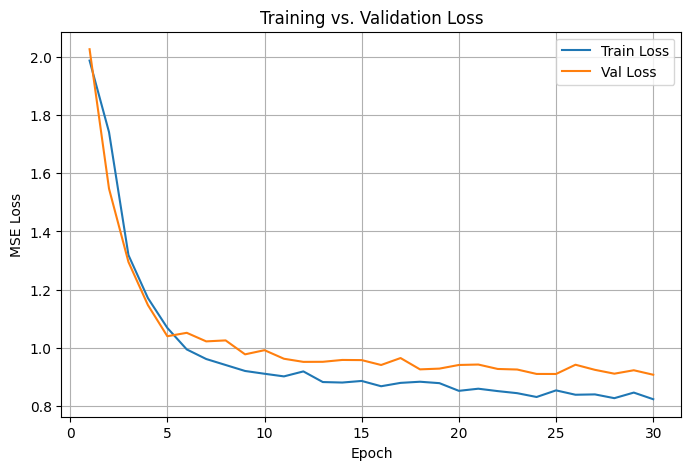

In [122]:
# 5) Complete training loop with tqdm bar and loss tracking
num_epochs = 30
train_losses = []
val_losses   = []

# Create a longer orange progress bar (hex for orange) with wider width
pbar = trange(
    1, num_epochs + 1,
    desc="Epochs",
    colour="#FFA500",
    ncols=120
)

for epoch in pbar:
    train_loss = train_epoch(train_loader)
    val_loss   = eval_epoch(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    pbar.set_postfix({
        "train_loss": f"{train_loss:.4f}",
        "val_loss":   f"{val_loss:.4f}"
    })

# After training, plot the training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


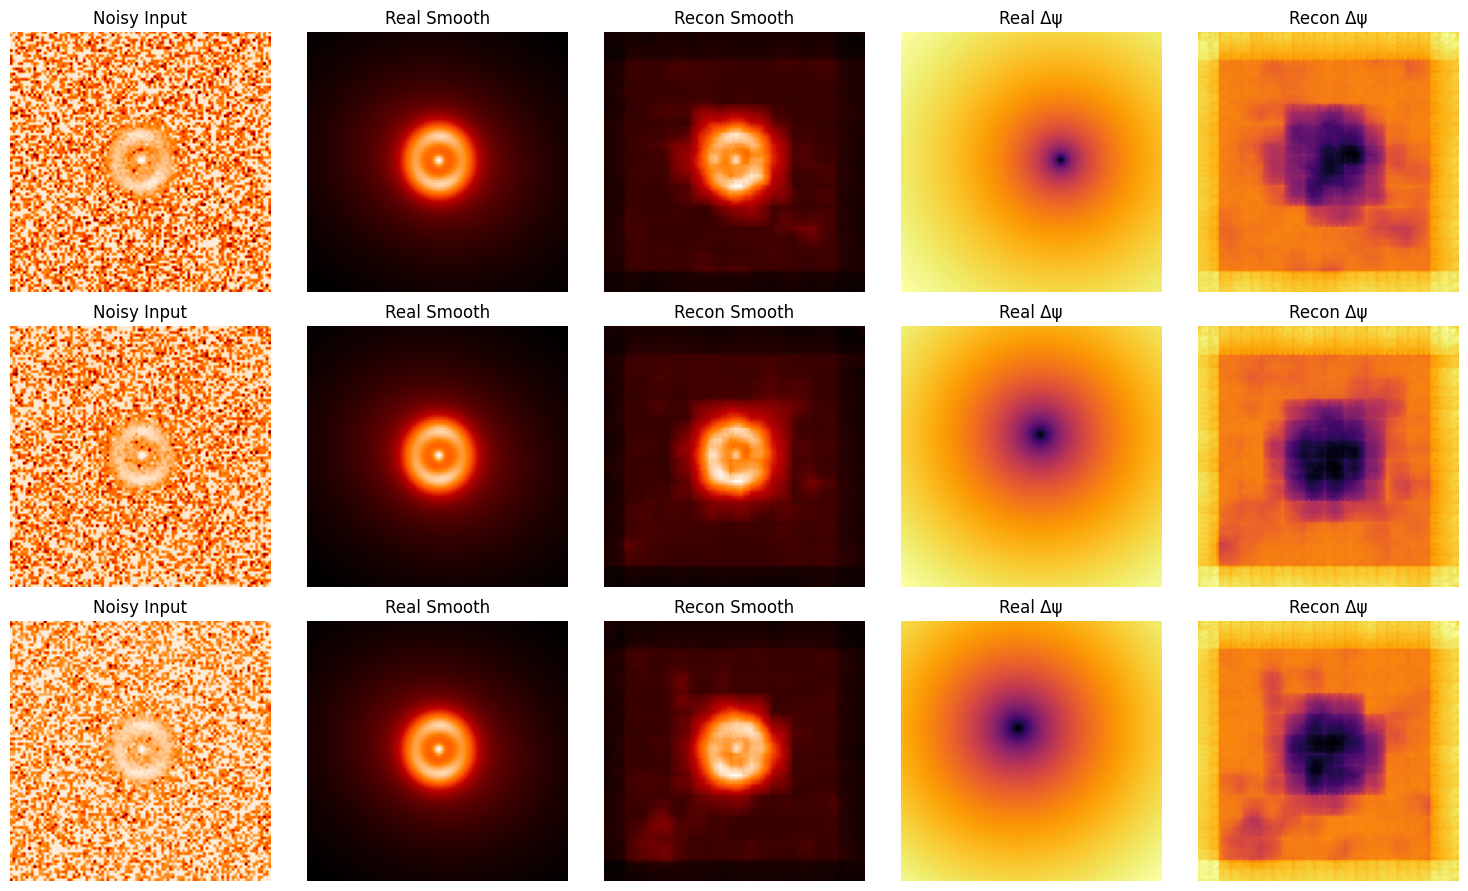

In [124]:
 
# 1) Saca un batch del val_loader
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    x, y_true_smooth, y_true_delta = batch
    x = x.to(device)
    y_true_smooth = y_true_smooth.to(device)
    y_true_delta = y_true_delta.to(device)
    y_pred_smooth, y_pred_delta = model(x)

# 2) Llévalos a CPU + NumPy
x_np           = x.cpu().numpy()
y_true_s_np    = y_true_smooth.cpu().numpy()
y_true_d_np    = y_true_delta.cpu().numpy()
y_pred_s_np    = y_pred_smooth.cpu().numpy()
y_pred_d_np    = y_pred_delta.cpu().numpy()

# 3) Plot para las primeras 3 muestras
n_samples = 3
fig, axes = plt.subplots(n_samples, 5, figsize=(15, 3*n_samples))
for i in range(n_samples):
    # Col 0: Entrada ruidosa
    axes[i,0].imshow(x_np[i,0], origin='lower', cmap='gist_heat')
    axes[i,0].set_title("Noisy Input")
    # Col 1: Smooth real
    axes[i,1].imshow(y_true_s_np[i,0], origin='lower', cmap='gist_heat')
    axes[i,1].set_title("Real Smooth")
    # Col 2: Smooth recon
    axes[i,2].imshow(y_pred_s_np[i,0], origin='lower', cmap='gist_heat')
    axes[i,2].set_title("Recon Smooth")
    # Col 3: Δψ real
    axes[i,3].imshow(y_true_d_np[i,0], origin='lower', cmap='inferno')
    axes[i,3].set_title("Real Δψ")
    # Col 4: Δψ recon
    axes[i,4].imshow(y_pred_d_np[i,0], origin='lower', cmap='inferno')
    axes[i,4].set_title("Recon Δψ")

    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()
